In [46]:
import os
from os import path

import pandas as pd
import numpy as np
import seaborn as sns #Seaborn for pretty heatmap :D
#https://medium.com/@dtuk81/confusion-matrix-visualization-fc31e3f30fea
import matplotlib.pyplot as plt

#Models tested.
import sklearn
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
#Need to enable experimental to use hist gradient boosting
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import GradientBoostingClassifier, HistGradientBoostingClassifier

#Librosa lib.
import librosa
import librosa.display

#Preprocessing / preformance metrics.
from sklearn.metrics import confusion_matrix, accuracy_score,f1_score
from sklearn import preprocessing
#import pickle
#import itertools

#Custom files.
from data_preprocessing import *
from data_analysis import *
from helpers import *

fileName = "features.dat"

data = load_binaryfile(fileName)

print("done loading")
data.head()

done loading


,classlabel,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,bandwidth_mean,bandwidth_var,centroid_mean,centroid_var,zero_crossing_mean,...,mfcc16_mean,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var
0,blues,0.335434,0.091088,0.130405,0.003521,1972.723622,117298.851326,1773.285877,168244.728448,0.081851,...,1.877616,2353.939941,1.576506,2219.069580,1.529033,2097.942871,1.183121,1991.447388,1.112082,1894.162476
1,blues,0.343020,0.086142,0.112699,0.001450,2009.201575,65548.531475,1816.195860,90703.325185,0.087173,...,2.379336,2452.845947,1.880546,2314.937988,1.788251,2189.285645,1.542793,2080.248535,1.755690,1980.097534
2,blues,0.346838,0.092210,0.132002,0.004620,2085.045996,74755.260660,1788.642783,111322.537051,0.071383,...,3.097872,2507.301514,2.809684,2362.796631,2.781829,2234.215820,2.533761,2120.529053,2.533194,2016.159058
3,blues,0.363671,0.086856,0.132562,0.002447,1959.202709,83672.222326,1654.902168,112316.264385,0.069426,...,2.298341,2454.086670,1.936131,2313.473877,1.898311,2186.921631,1.607881,2076.045410,1.709453,1974.035522
4,blues,0.335927,0.088291,0.143289,0.001701,1948.459295,60221.595017,1630.737017,79648.228297,0.070102,...,3.648756,2288.108154,3.471156,2156.658691,3.373302,2039.879761,3.016701,1936.210938,2.893213,1841.151001


Splitting and creating test train set.

In [47]:
y = data.classlabel
X = data.drop('classlabel',axis=1)

cols = X.columns
min_max_scaler = preprocessing.MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(X)

X = pd.DataFrame(np_scaled, columns = cols)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

Def for assessing model, and test of multiple models.

In [21]:
def model_assess(model, title = "Default"):
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    score = accuracy_score(y_test, preds) * 100 #* 100 for procent
    print(f'Accuracy {title} : {score:4.3f}%\n')

In [22]:
nb = GaussianNB()
model_assess(nb, "Naive Bayes")

sgd = SGDClassifier()
model_assess(sgd, "Stochastic Gradient Descent")

knn = KNeighborsClassifier()
model_assess(knn, "KNN")

tree = DecisionTreeClassifier()
model_assess(tree, "Decission trees")

rforest = RandomForestClassifier()
model_assess(rforest, "Random Forest")

svm = SVC()
model_assess(svm, "Support Vector Machine")

lg = LogisticRegression()
model_assess(lg, "Logistic Regression")

nn = MLPClassifier()
model_assess(nn, "MLP")

grad = GradientBoostingClassifier()
model_assess(grad,"Gradient boost")

#Hist klart bedste score - men experimental, så på nuværende ikke "fremtids sikker"
hist = HistGradientBoostingClassifier()
model_assess(hist,"Hist gradient boost")

xgb = XGBClassifier()
model_assess(xgb, "Cross Gradient Booster")

Accuracy Naive Bayes : 38.539%

Accuracy Stochastic Gradient Descent : 51.285%

Accuracy KNN : 78.345%

Accuracy Decission trees : 65.632%

Accuracy Random Forest : 83.317%

Accuracy Support Vector Machine : 59.393%



C:\Users\jonas\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy Logistic Regression : 57.357%



C:\Users\jonas\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Accuracy MLP : 65.232%

Accuracy Gradient boost : 77.978%

Accuracy Hist gradient boost : 87.654%

Accuracy Cross Gradient Booster : 86.720%



Grid search for selected model.

In [85]:
from sklearn.model_selection import GridSearchCV

model = XGBClassifier()

params = [{
    'eta':[1e-5,1e-3,1e-1,2e-1,3e-1,4e-1,5e-1,1],
    'max_depth':[5,10,20,40,100],
    'subsample':[0.5,1],
    'sampling_method':['uniform'],
    'tree_method':['exact','approx','hist'],
    'grow_policy':['depthwise','lossguide']
}]
#Findes flere sampling måder - men virker kun GPU based
#subsample < 1, skulle gerne skal tjek for overfitting.
#Eta = learning rate.

grid_tuned = GridSearchCV(estimator=model,
                         param_grid=params,
                         cv=5,
                         scoring='accuracy',
                         verbose=False,
                         iid=True,
                         n_jobs=-1)

grid_tuned.fit(X_train,y_train)


C:\Users\jonas\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs...
                                     scale_pos_weight=None, subsample=None,
                                     tree_method=None, validate_parameters=None,
                                     verbosity=None),
             iid=True, n_jobs=-1,
             param_grid=[{'eta': [1e-0

In [87]:
print("best params:",grid_tuned.best_params_)
print("best score:",grid_tuned.best_score_)

best params: {'eta': 0.4, 'grow_policy': 'depthwise', 'max_depth': 5, 'sampling_method': 'uniform', 'subsample': 1, 'tree_method': 'approx'}
best score: 0.8395538395538396


Random search for selected model

In [41]:
from sklearn.model_selection import RandomizedSearchCV

model = XGBClassifier()

params = [{
    'eta':[1e-5,1e-3,1e-1,2e-1,3e-1,4e-1,5e-1,1],
    'max_depth':[5,10,20,40,100],
    'subsample':[0.5,1],
    'sampling_method':['uniform'],
    'tree_method':['exact','approx','hist'],
    'grow_policy':['depthwise','lossguide']
}]

Grid_tune = RandomizedSearchCV(estimator=model,param_distributions=params,scoring='accuracy',
                              random_state=42,n_jobs=-1)

Grid_tune.fit(X_train,y_train)

RandomizedSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100, n_job...
                                           scale_pos_weight=None,
                                           subsample=None, tree_method=None,
                                           validate_param

In [42]:
print("best params:",Grid_tune.best_params_)
print("best score:",Grid_tune.best_score_)

best params: {'tree_method': 'approx', 'subsample': 1, 'sampling_method': 'uniform', 'max_depth': 5, 'grow_policy': 'lossguide', 'eta': 0.5}
best score: 0.8339767522479269


Fitting both models and checking for fitness.

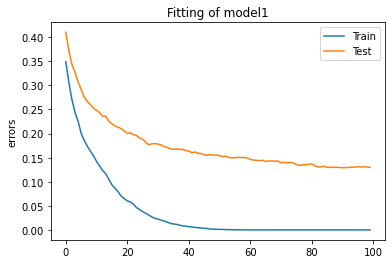

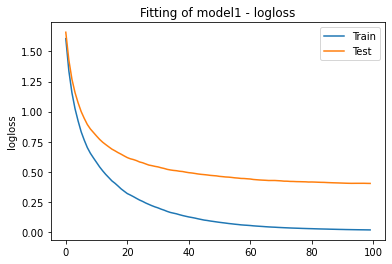

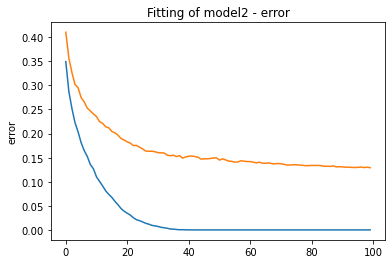

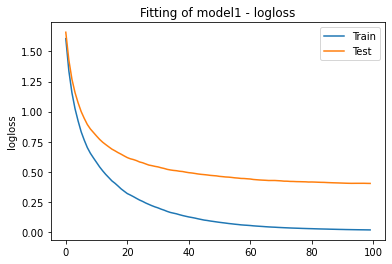

In [48]:
#best model / gridsearch
eval_set = [(X_train,y_train),(X_test,y_test)]
model = XGBClassifier(eta = 0.4,
                      grow_policy = 'depthwise',
                      max_depth = 5,
                      sampling_method = 'uniform',
                      subsample = 1,
                      tree_method = 'approx'
                     )
#Random search
model2 = XGBClassifier(eta = 0.5,
                      tree_method='approx',
                      subsample=1,
                      sampling_method='uniform',
                      max_depth=5,
                      grow_policy='lossguide'
                      )

model.fit(X_train,y_train,early_stopping_rounds=10,eval_metric=["merror", "mlogloss"],
          eval_set=eval_set,verbose=False)
model2.fit(X_train,y_train,early_stopping_rounds=10,eval_metric=["merror", "mlogloss"],
           eval_set=eval_set,verbose=False)

results = model.evals_result()
results2 = model2.evals_result()

epochs1 = len(results['validation_0']['merror'])
epochs2 = len(results2['validation_0']['merror'])

x_axis1 = range(0,epochs1)
x_axis2 = range(0,epochs2)

fig,ax = plt.subplots()
ax.plot(x_axis1,results['validation_0']['merror'],label='Train')
ax.plot(x_axis1,results['validation_1']['merror'],label='Test')
ax.legend()
plt.ylabel('errors')
plt.title('Fitting of model1')

fig,ax = plt.subplots()
ax.plot(x_axis1,results['validation_0']['mlogloss'],label='Train')
ax.plot(x_axis1,results['validation_1']['mlogloss'],label='Test')
ax.legend()
plt.ylabel('logloss')
plt.title('Fitting of model1 - logloss')

fig,ax = plt.subplots()
ax.plot(x_axis2,results2['validation_0']['merror'],label='Train')
ax.plot(x_axis2,results2['validation_1']['merror'],label='Test')
ax.legend
plt.ylabel('error')
plt.title('Fitting of model2 - error')

fig,ax = plt.subplots()
ax.plot(x_axis1,results['validation_0']['mlogloss'],label='Train')
ax.plot(x_axis1,results['validation_1']['mlogloss'],label='Test')
ax.legend()
plt.ylabel('logloss')
plt.title('Fitting of model1 - logloss')

plt.show()

Getting performance for both models.

In [49]:
from sklearn.metrics import precision_score, recall_score
#Der bruges macro da alle klasser anses for værende lige - 100 sange pr klasse.

preds1 = model.predict(X_test)

Acc_score = accuracy_score(y_test, preds1) * 100 #* 100 for procent
recall1 = recall_score(y_test,preds1,average='macro') * 100
precision1 = precision_score(y_test,preds1,average='macro') * 100

print(f'Model 1 Accuracy:{Acc_score:.3f}%   Recall:{recall1:.3f}%   Precision:{precision1:.3f}% \n')

preds2 =model2.predict(X_test)

Acc_score2 = accuracy_score(y_test,preds2) * 100
recall2 = recall_score(y_test,preds2,average='macro') * 100
precision2 = precision_score(y_test,preds2,average='macro') * 100

print(f'Model 2 Accuracy:{Acc_score2:.3f}%   Recall:{recall2:.3f}%   Precision:{precision2:.3f}% \n')

Model 1 Accuracy:86.987%   Recall:86.972%   Precision:86.993% 

Model 2 Accuracy:86.987%   Recall:86.984%   Precision:87.037% 



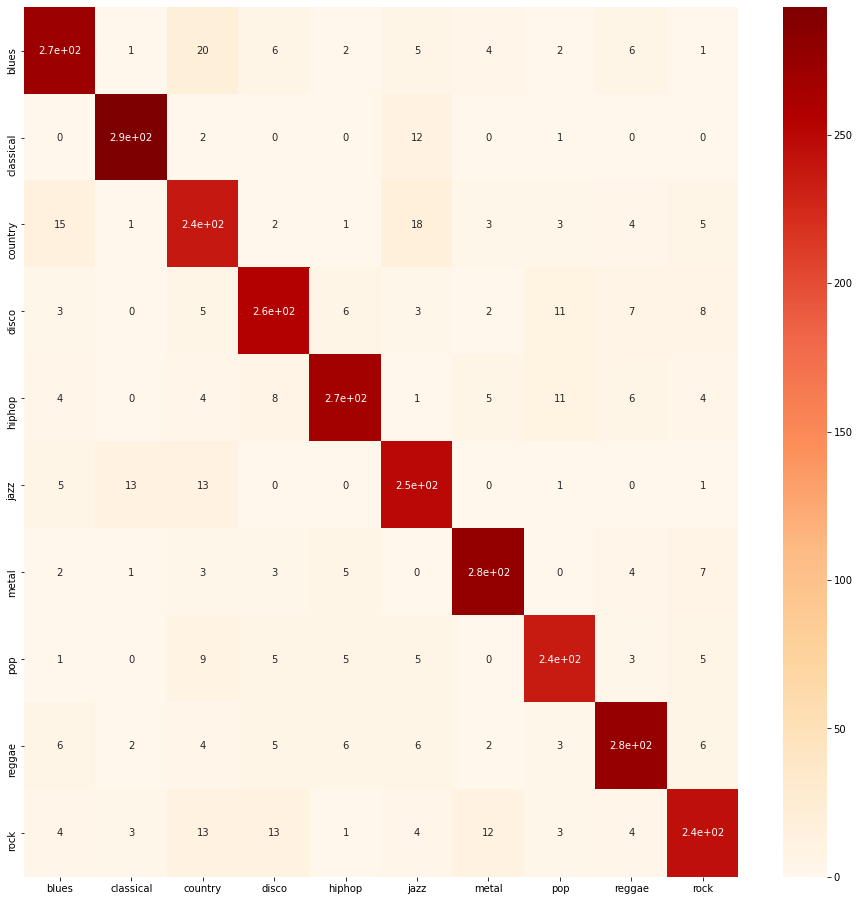

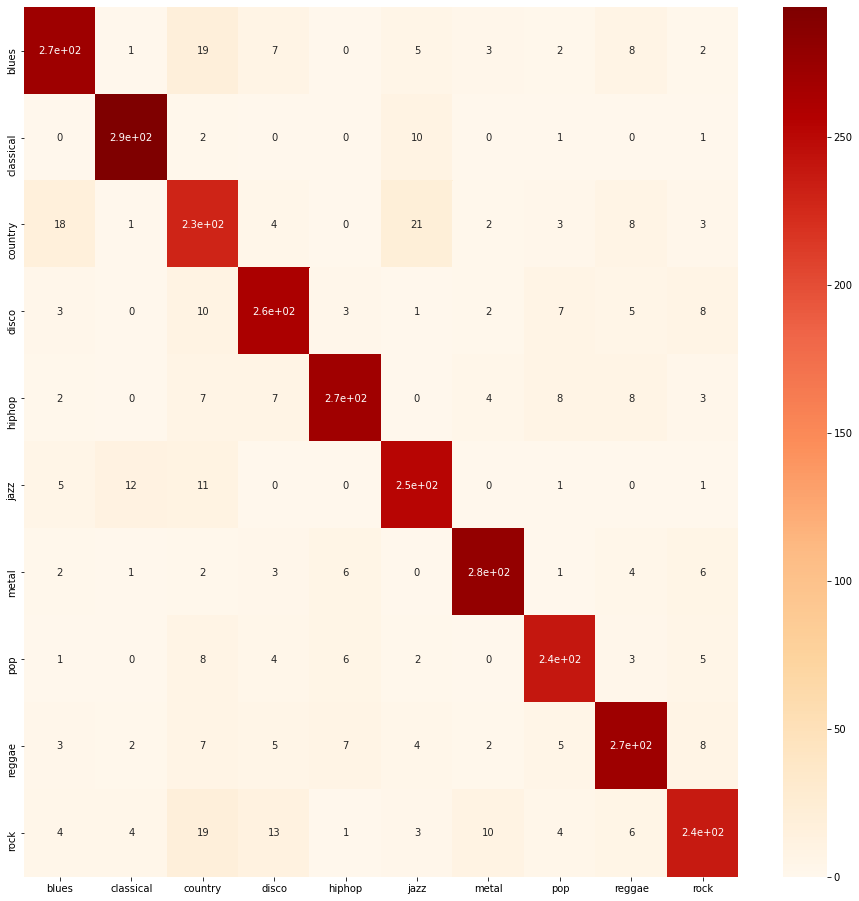

In [50]:
# Confusion matrix

conf_m = confusion_matrix(y_test,preds1)

plt.figure(figsize = (16,16))
labels = ["blues", "classical", "country", "disco","hiphop", "jazz", "metal", "pop", "reggae", "rock"] 
sns.heatmap(conf_m,annot=True,cmap='OrRd',xticklabels=labels,yticklabels=labels)

conf_m2 = confusion_matrix(y_test,preds2)

plt.figure(figsize = (16,16))
labels = ["blues", "classical", "country", "disco","hiphop", "jazz", "metal", "pop", "reggae", "rock"] 
sns.heatmap(conf_m2,annot=True,cmap='OrRd',xticklabels=labels,yticklabels=labels)

In [26]:
#Testing predictions on real data.

def make_predict(pathtofile,expect):
    to_test = get_features(pathtofile)
    to_test = to_test.drop('classlabel',axis=1)
    pred = model.predict(to_test)
    print(f'Expect:{expect}, got:{pred}')

path = "C:/Users/jonas/AU/s5/MAL/opgaver/Data/genres_original/rock/rock.00010.wav"
make_predict(path,"rock")

path = "C:/Users/jonas/AU/s5/MAL/opgaver/Data/genres_original/pop/pop.00010.wav"
make_predict(path,"pop")

path = "C:/Users/jonas/AU/s5/MAL/opgaver/Data/genres_original/reggae/reggae.00010.wav"
make_predict(path,"reggae")

path = "C:/Users/jonas/AU/s5/MAL/opgaver/Data/genres_original/classical/classical.00010.wav"
make_predict(path,"classical")

path = "C:/Users/jonas/AU/s5/MAL/opgaver/Data/genres_original/blues/blues.00010.wav"
make_predict(path,"blues")

Expect:rock, got:['rock']
Expect:pop, got:['pop']
Expect:reggae, got:['pop']
Expect:classical, got:['classical']
Expect:blues, got:['pop']


Running tests on csv dataset to see how well constructed datasets preform.

In [9]:
csvdata = pd.read_csv('C:/Users/jonas/AU/s5/MAL/opgaver/Data/features_3_sec.csv')

csvdata.head()

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.0.wav,66149,0.335406,0.091048,0.130405,0.003521,1773.065032,167541.630869,1972.744388,117335.771563,...,39.687145,-3.241280,36.488243,0.722209,38.099152,-5.050335,33.618073,-0.243027,43.771767,blues
1,blues.00000.1.wav,66149,0.343065,0.086147,0.112699,0.001450,1816.693777,90525.690866,2010.051501,65671.875673,...,64.748276,-6.055294,40.677654,0.159015,51.264091,-2.837699,97.030830,5.784063,59.943081,blues
2,blues.00000.2.wav,66149,0.346815,0.092243,0.132003,0.004620,1788.539719,111407.437613,2084.565132,75124.921716,...,67.336563,-1.768610,28.348579,2.378768,45.717648,-1.938424,53.050835,2.517375,33.105122,blues
3,blues.00000.3.wav,66149,0.363639,0.086856,0.132565,0.002448,1655.289045,111952.284517,1960.039988,82913.639269,...,47.739452,-3.841155,28.337118,1.218588,34.770935,-3.580352,50.836224,3.630866,32.023678,blues
4,blues.00000.4.wav,66149,0.335579,0.088129,0.143289,0.001701,1630.656199,79667.267654,1948.503884,60204.020268,...,30.336359,0.664582,45.880913,1.689446,51.363583,-3.392489,26.738789,0.536961,29.146694,blues


In [10]:
csvdata = csvdata.iloc[0:, 1:]
y = csvdata['label']
X = csvdata.loc[:, csvdata.columns != 'label']

cols = X.columns
min_max_scaler = preprocessing.MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(X)
X = pd.DataFrame(np_scaled, columns = cols)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

eval_set = [(X_test,y_test)]
model = XGBClassifier(eta = 0.4,
                      grow_policy = 'depthwise',
                      max_depth = 5,
                      sampling_method = 'uniform',
                      subsample = 1,
                      tree_method = 'approx'
                     )

model.fit(X_train,y_train,early_stopping_rounds=10,eval_metric="merror",eval_set=eval_set,verbose=True)

preds = model.predict(X_test)

Acc_score = accuracy_score(y_test, preds) * 100 #* 100 for procent
recall1 = recall_score(y_test,preds,average='macro') * 100
precision1 = precision_score(y_test,preds,average='macro') * 100

print(f'Model Accuracy:{Acc_score:.3f}%   Recall:{recall1:.3f}%   Precision:{precision1:.3f}% \n')

[0]	validation_0-merror:0.38238
Will train until validation_0-merror hasn't improved in 10 rounds.
[1]	validation_0-merror:0.33901
[2]	validation_0-merror:0.30464
[3]	validation_0-merror:0.28629
[4]	validation_0-merror:0.27094
[5]	validation_0-merror:0.25692
[6]	validation_0-merror:0.23924
[7]	validation_0-merror:0.23090
[8]	validation_0-merror:0.21822
[9]	validation_0-merror:0.20988
[10]	validation_0-merror:0.20187
[11]	validation_0-merror:0.19253
[12]	validation_0-merror:0.18919
[13]	validation_0-merror:0.18619
[14]	validation_0-merror:0.17918
[15]	validation_0-merror:0.17751
[16]	validation_0-merror:0.17517
[17]	validation_0-merror:0.17284
[18]	validation_0-merror:0.16583
[19]	validation_0-merror:0.16383
[20]	validation_0-merror:0.15916
[21]	validation_0-merror:0.15616
[22]	validation_0-merror:0.14948
[23]	validation_0-merror:0.14781
[24]	validation_0-merror:0.14281
[25]	validation_0-merror:0.14114
[26]	validation_0-merror:0.13814
[27]	validation_0-merror:0.13780
[28]	validation_0-m

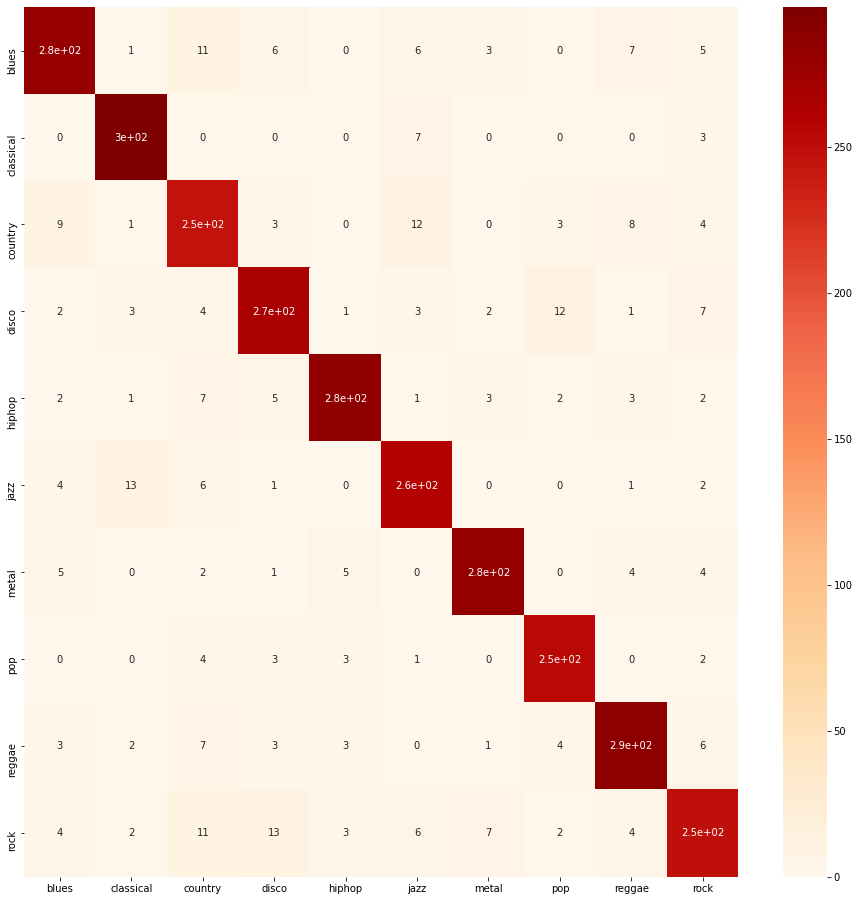

In [117]:
conf_m = confusion_matrix(y_test,preds)

plt.figure(figsize = (16,16))
labels = ["blues", "classical", "country", "disco","hiphop", "jazz", "metal", "pop", "reggae", "rock"] 
sns.heatmap(conf_m,annot=True,cmap='OrRd',xticklabels=labels,yticklabels=labels)